# ✅ Project: General Customer Support Ticket Classification
## 📌 Project Title: Customer Support Ticket Type Classification using Combined Features (Text + Categorical + Numerical)

### 📖 Description:
- In this project, a multi-class classification system is built to predict the Ticket Type of customer support tickets based on fields like ticket description, priority, channel, and product. It combines TF-IDF or SentenceTransformer embeddings of ticket descriptions with encoded categorical and numeric features.

### 🧱 Notebook Structure & Sections

### ✅ 1. Importing Required Libraries
- Start by importing essential libraries (pandas, numpy, seaborn, sklearn, xgboost, lightgbm, matplotlib, etc.).

In [77]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

### 📊 2. Data Loading & Exploration:
- Dataset was loaded and it was downloaded from Kaggle.
- Inspected and visualized for understanding data balance.

In [78]:
#Data Loading and Inspecting the Data
df = pd.read_csv('customer_support_tickets.csv')

In [79]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [81]:
df.describe()

,Ticket ID,Customer Age,Customer Satisfaction Rating
count,8469.000000,8469.000000,2769.000000
mean,4235.000000,44.026804,2.991333
std,2444.934048,15.296112,1.407016
min,1.000000,18.000000,1.000000
25%,2118.000000,31.000000,2.000000
50%,4235.000000,44.000000,3.000000
75%,6352.000000,57.000000,4.000000
max,8469.000000,70.000000,5.000000


In [82]:
df.isnull().sum()

Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

### ✅ 3. Data Cleaning:
- Removed irrelevant columns like name, email, resolution, satisfaction rating, etc.
- Handled missing values.

In [83]:
df.drop(['Ticket ID', 'Customer Name', 'Customer Email', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating', 'Resolution'], axis = 1,inplace = True)

In [84]:
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
reference_date = df['Date of Purchase'].max()

In [85]:
df['Days Since Purchase'] = (reference_date - df['Date of Purchase']).dt.days

In [86]:
df.drop('Date of Purchase', axis = 1, inplace = True)

In [87]:
df['Full Description'] = df['Product Purchased'].fillna('').astype(str) + ' ' + df['Ticket Subject'].fillna('').astype(str) + ' ' + df['Ticket Description'].fillna('').astype(str)

In [88]:
def replace_product_placeholder(row):
    desc = row['Full Description']
    product = row['Product Purchased']
    
    if isinstance(desc, str) and '{product_purchased}' in desc and isinstance(product, str):
        return desc.replace('{product_purchased}', product)
    return desc

df['Full Description'] = df.apply(replace_product_placeholder, axis=1)

In [89]:
df.drop(['Product Purchased', 'Ticket Subject', 'Ticket Description'], axis = 1, inplace = True)

In [90]:
df.head()

,Customer Age,Customer Gender,Ticket Type,Ticket Status,Ticket Priority,Ticket Channel,Days Since Purchase,Full Description
0,32,Other,Technical issue,Pending Customer Response,Critical,Social media,283,GoPro Hero Product setup I'm having an issue w...
1,42,Female,Technical issue,Pending Customer Response,Critical,Chat,222,LG Smart TV Peripheral compatibility I'm havin...
2,48,Other,Technical issue,Closed,Low,Social media,534,Dell XPS Network problem I'm facing a problem ...
3,27,Female,Billing inquiry,Closed,Low,Social media,412,Microsoft Office Account access I'm having an ...
4,67,Female,Billing inquiry,Closed,Low,Email,695,Autodesk AutoCAD Data loss I'm having an issue...


In [91]:
df.isnull().sum()

Customer Age           0
Customer Gender        0
Ticket Type            0
Ticket Status          0
Ticket Priority        0
Ticket Channel         0
Days Since Purchase    0
Full Description       0
dtype: int64

### ✅ 4. Exploratory Data Analysis (EDA)
- Count plots for categorical columns
- Box plots for numerical features to check outliers
- Visualized target class balance (classification: Types of Ticket Priority)

In [92]:
#Seprating Numerical and Categorical Columns
numerical_columns = ['Customer Age' , 'Days Since Purchase']
categorical_columns = ['Customer Gender', 'Ticket Type', 'Ticket Status', 'Ticket Channel']
full_text = 'Full Description'
target = 'Ticket Priority'

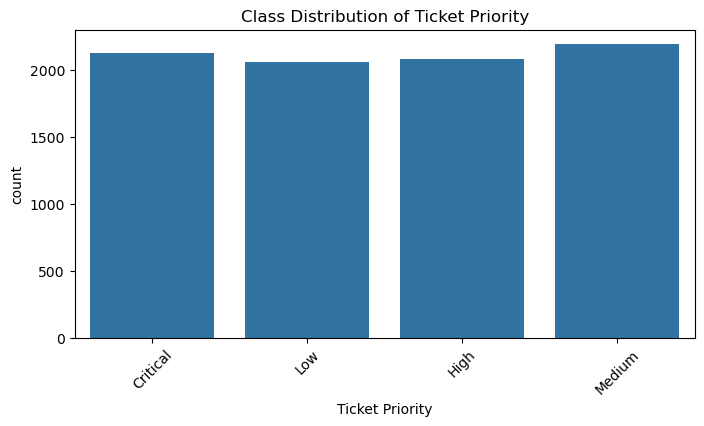

In [93]:
#Checking Class Imabalance in Target Variable
plt.figure(figsize=(8, 4))
sns.countplot(x=target, data=df)
plt.title(f'Class Distribution of {target}')
plt.xticks(rotation=45)
plt.show()

In [94]:
# Check percentage distribution of target classes
class_counts = df[target].value_counts(normalize=True) * 100
print(class_counts)

Ticket Priority
Medium      25.882631
Critical    25.138741
High        24.619199
Low         24.359429
Name: proportion, dtype: float64


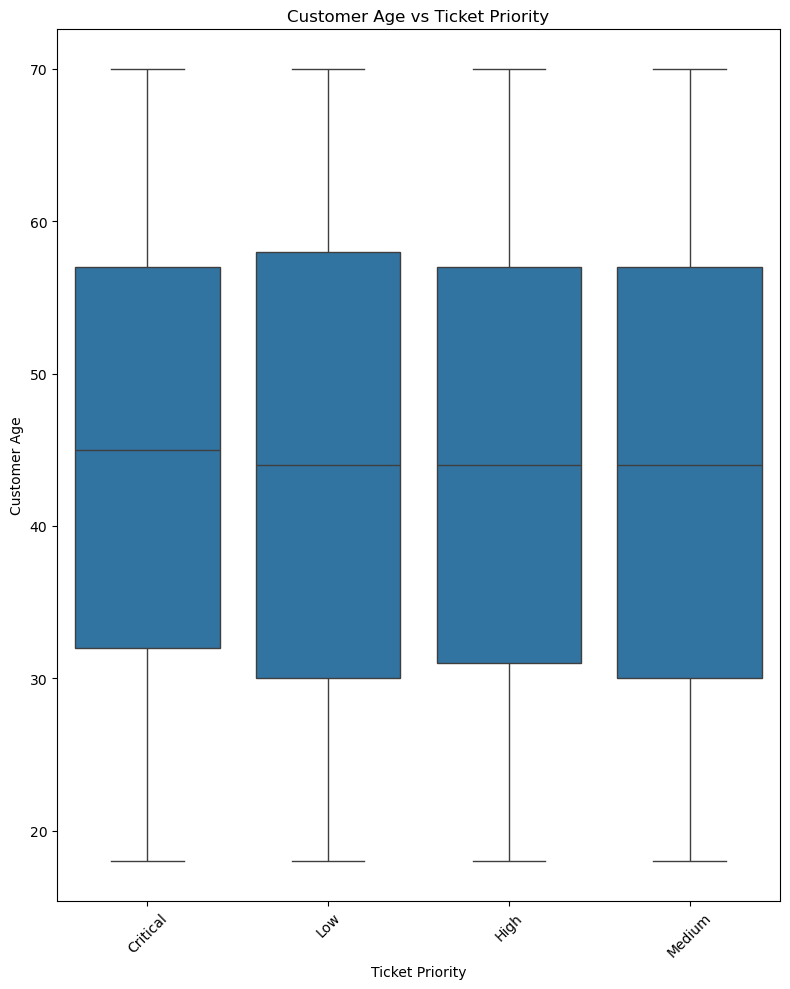

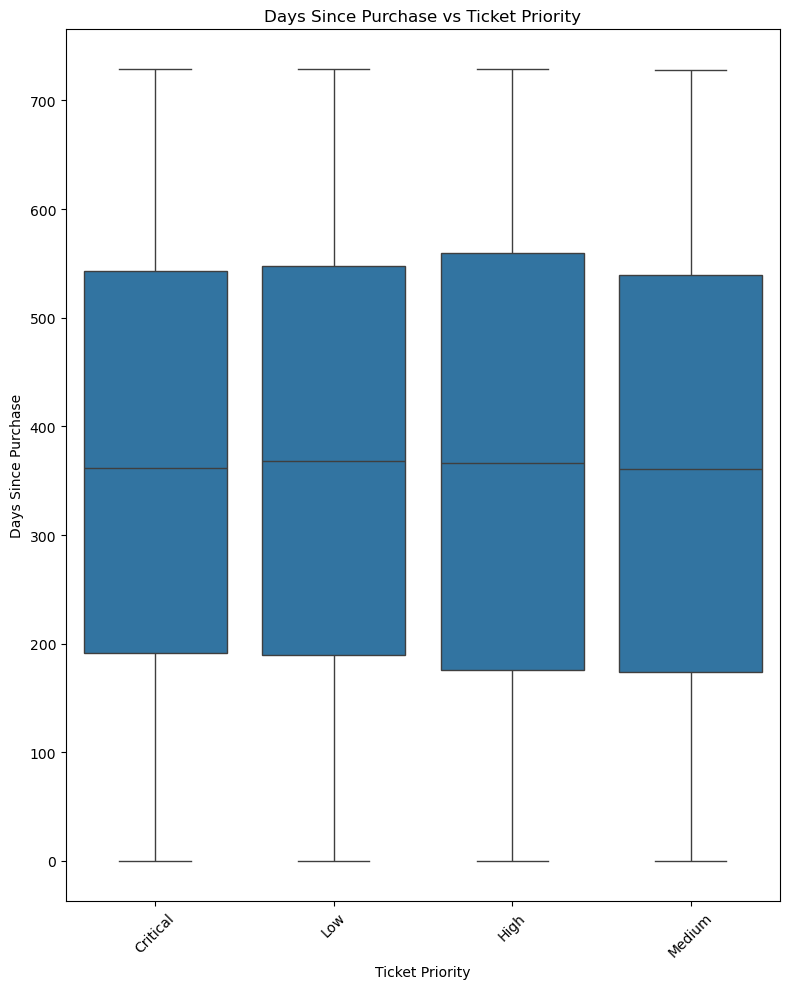

In [95]:
for col in numerical_columns:
    plt.figure(figsize=(8, 10))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f'{col} vs {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('\n')

In [96]:
for col in numerical_columns:
  print(f'{col} Skewness ', skew(df[col]))

Customer Age Skewness  -0.017169234671005965
Days Since Purchase Skewness  0.003673374821769723


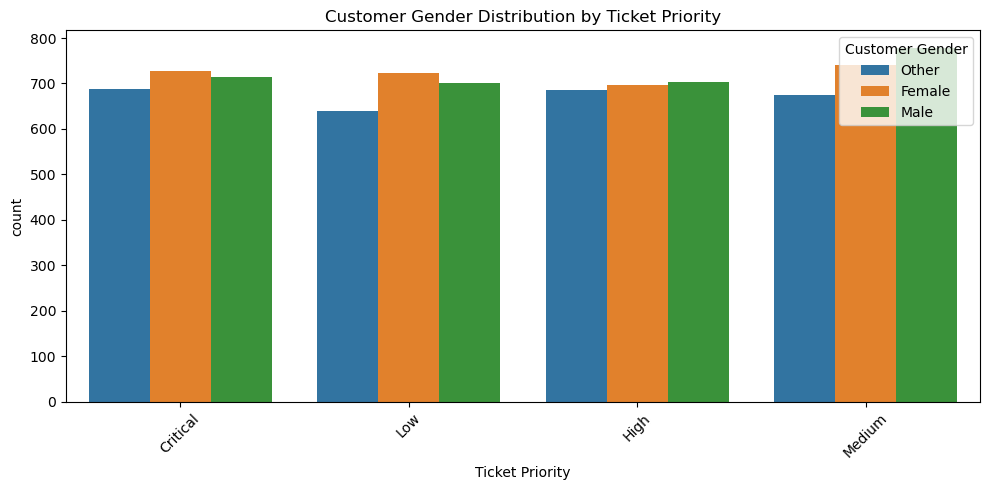

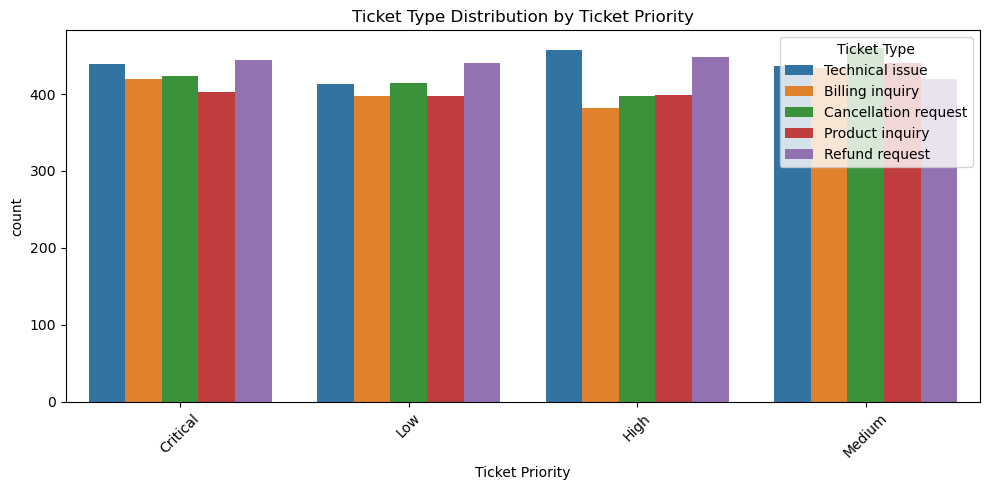

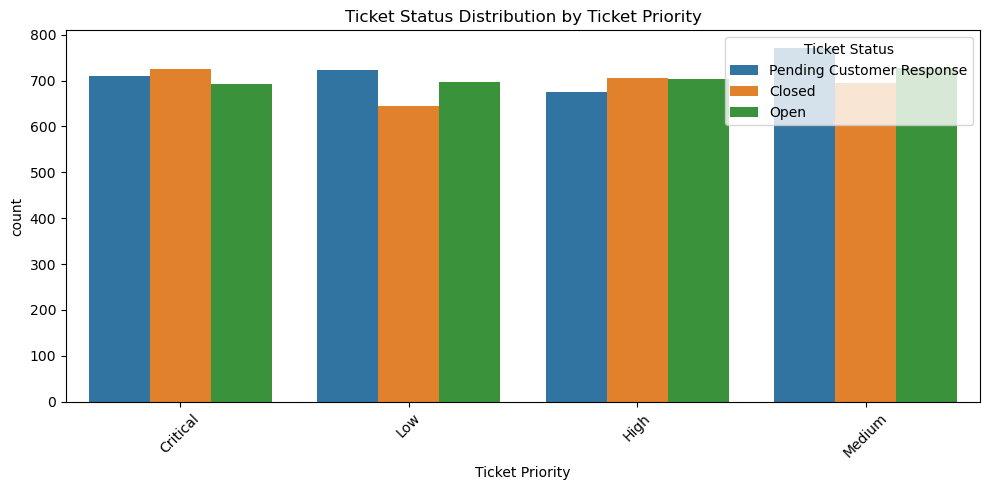

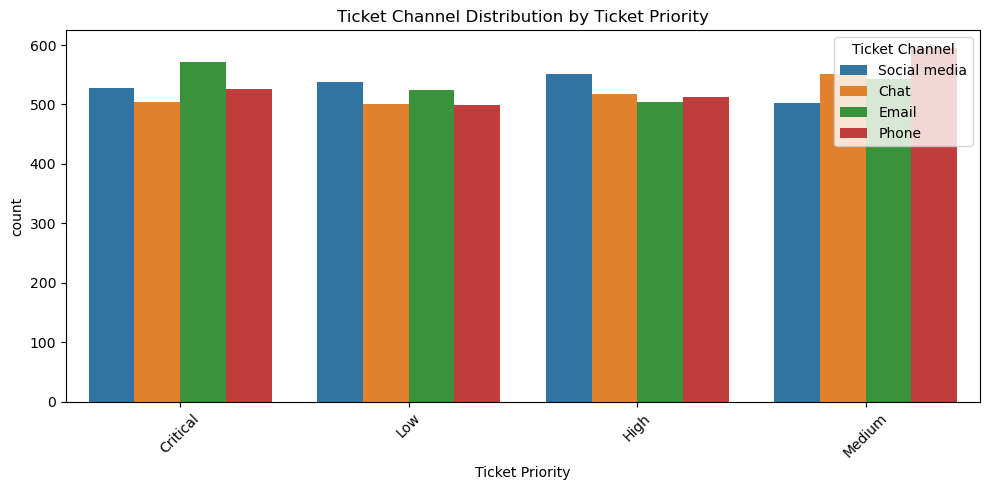

In [97]:
for col in categorical_columns:
    #top_hue_values = df[col].value_counts().nlargest(15).index
    #filtered_df = df[df[col].isin(top_hue_values)]
    plt.figure(figsize=(10,5))
    sns.countplot(x=target, hue=col, data=df)
    plt.title(f'{col} Distribution by {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

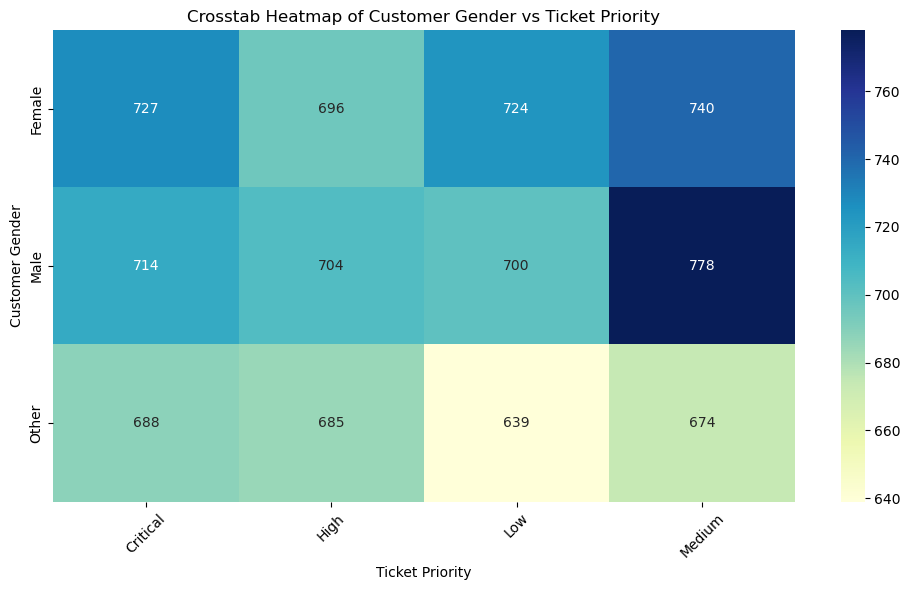

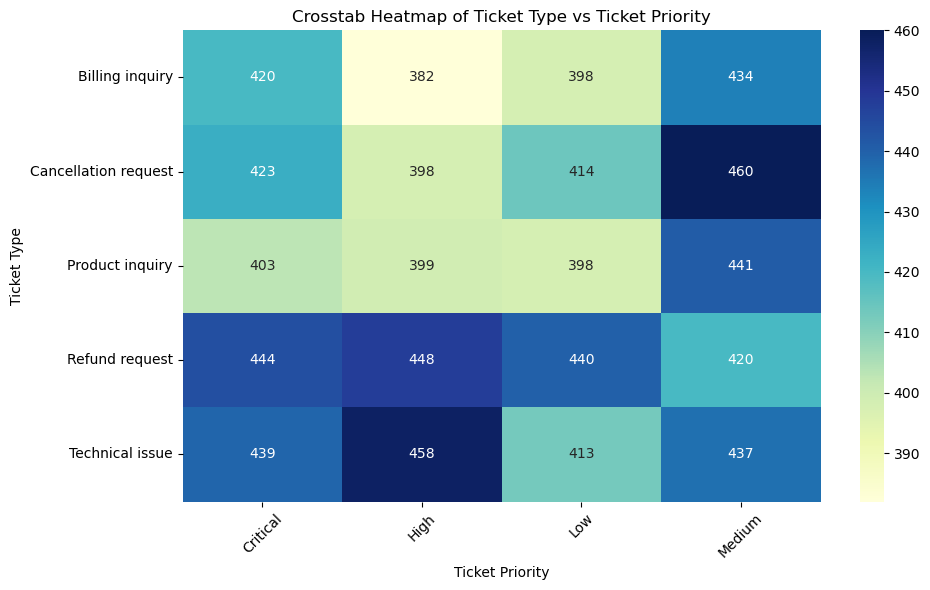

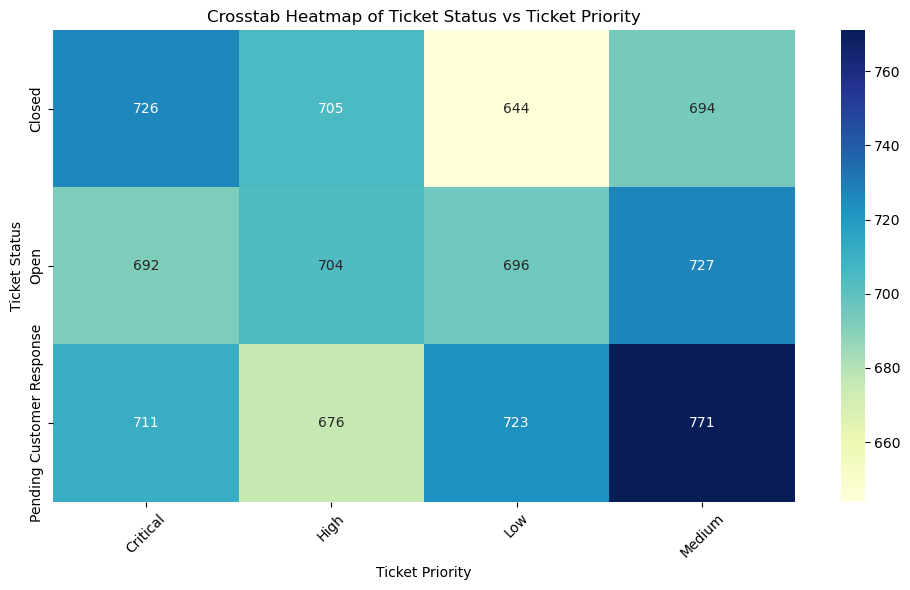

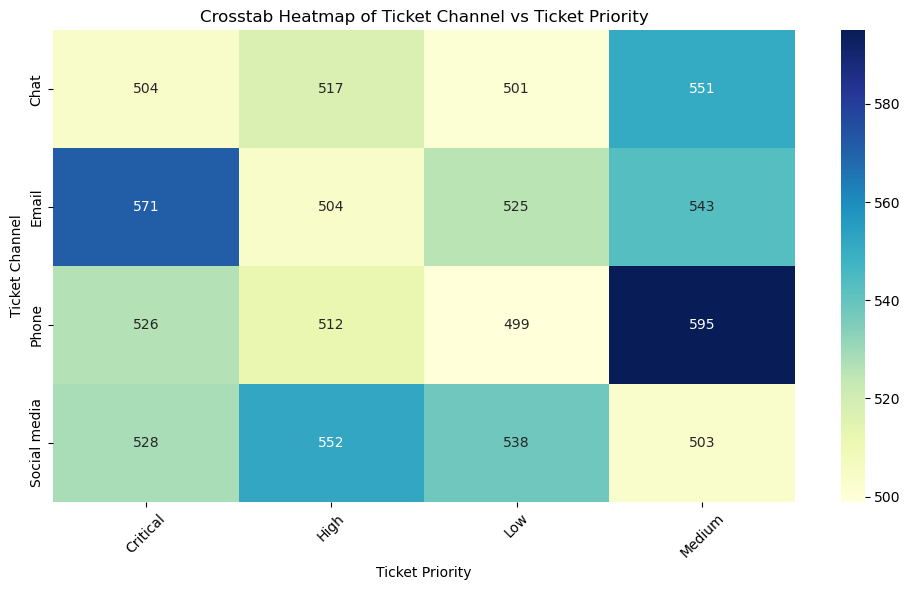

In [98]:
for col in categorical_columns:
    ct = pd.crosstab(df[col], df[target])
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f'Crosstab Heatmap of {col} vs {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('\n')

In [99]:
for col in categorical_columns:
  print(f'\n{col} Distributions', df[col].value_counts(normalize = True)*100)


Customer Gender Distributions Customer Gender
Male      34.195301
Female    34.089031
Other     31.715669
Name: proportion, dtype: float64

Ticket Type Distributions Ticket Type
Refund request          20.687212
Technical issue         20.628173
Cancellation request    20.014169
Product inquiry         19.376550
Billing inquiry         19.293895
Name: proportion, dtype: float64

Ticket Status Distributions Ticket Status
Pending Customer Response    34.018184
Open                         33.286102
Closed                       32.695714
Name: proportion, dtype: float64

Ticket Channel Distributions Ticket Channel
Email           25.304050
Phone           25.174165
Social media    25.044279
Chat            24.477506
Name: proportion, dtype: float64


### ✅ 5. Train-Test Split

In [100]:
X = df.drop(target, axis = 1)
y = df[target]

In [101]:
le = LabelEncoder()
y = le.fit_transform(df[target])

In [102]:
# Splitting the Data for LLM
X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(X, y, test_size=0.25, random_state=42)

### ✅ 6. Feature Engineering
- Used TF-IDF to transform full_text (For TF-IDF)
- (Tried to Use SentenceTransformer for full_text (For LLM) but not getting better results than TFIDF)
- Handled categorical and numerical variables, using OneHotEncoder and StandardScaler
- Combined all features (embedding + encoded cat + num) using np.hstack

In [103]:
'''
# Load a lightweight, high-performing model
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embed = embedder.encode(X_train_llm[full_text].astype(str).tolist(), show_progress_bar=True)
X_test_embed = embedder.encode(X_test_llm[full_text].astype(str).tolist(), show_progress_bar=True)
'''

"\n# Load a lightweight, high-performing model\nembedder = SentenceTransformer('all-MiniLM-L6-v2')\nX_train_embed = embedder.encode(X_train_llm[full_text].astype(str).tolist(), show_progress_bar=True)\nX_test_embed = embedder.encode(X_test_llm[full_text].astype(str).tolist(), show_progress_bar=True)\n"

In [104]:
#Initialize and fit TF-IDF
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X_train_embed = tfidf.fit_transform(X_train_llm[full_text]).toarray()
X_test_embed = tfidf.transform(X_test_llm[full_text]).toarray()

In [105]:
ohe_categorical_columns = categorical_columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe_cat = ohe.fit_transform(X_train_llm[ohe_categorical_columns])
X_test_ohe_cat = ohe.transform(X_test_llm[ohe_categorical_columns])

In [106]:
# --- Scale numeric ---
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train_llm[numerical_columns])
X_test_num = sc.transform(X_test_llm[numerical_columns])

In [107]:
# --- Concatenate all ---
X_train_llm = np.hstack([X_train_embed, X_train_ohe_cat, X_train_num])
X_test_llm = np.hstack([X_test_embed, X_test_ohe_cat, X_test_num])

In [108]:
X_train_llm.shape, X_test_llm.shape

((6351, 1017), (2118, 1017))

In [109]:
'''
## --- Recuding Dimensions ---
pca = PCA(n_components=100, random_state=42)
X_train_llm = pca.fit_transform(X_train_llm)
X_test_llm = pca.transform(X_test_llm)
'''

'\n## --- Recuding Dimensions ---\npca = PCA(n_components=100, random_state=42)\nX_train_llm = pca.fit_transform(X_train_llm)\nX_test_llm = pca.transform(X_test_llm)\n'

### ✅ 7. Model Training:
- Modeling: TF-IDF Based Pipeline
- Trained Random Forest, Logistic Regression, KNN, SVM, K-means
- Evaluated using classification report.

In [110]:
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=4),
    'SVM': SVC(probability=True, random_state=42)
}

In [111]:
for name, model in models.items():
    model.fit(X_train_llm, y_train_llm)
    y_pred_llm = model.predict(X_test_llm)
    
    print(f"\n🔍 {name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test_llm, y_pred_llm))
    print("Classification Report:\n", classification_report(y_test_llm, y_pred_llm))

    # --- Get Nearest Neighbors for First Test Sample ---
    if name == 'KNN':
        distances, indices = model.kneighbors(X_test_llm[:1])  # first test instance
        print(f"\n📌 Nearest Neighbors for First Test Sample:")
        print("Indices:", indices[0])
        print("Distances:", distances[0])
        print("Neighbor Labels:", y_train_llm[indices[0]])


🔍 Random Forest Evaluation:
Accuracy: 0.2497639282341832
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.27      0.25       518
           1       0.24      0.26      0.25       500
           2       0.26      0.21      0.23       540
           3       0.27      0.26      0.27       560

    accuracy                           0.25      2118
   macro avg       0.25      0.25      0.25      2118
weighted avg       0.25      0.25      0.25      2118


🔍 Logistic Regression Evaluation:
Accuracy: 0.2516525023607177
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.26      0.26       518
           1       0.24      0.27      0.25       500
           2       0.25      0.19      0.22       540
           3       0.27      0.28      0.27       560

    accuracy                           0.25      2118
   macro avg       0.25      0.25      0.25      2118
weighted avg   

In [112]:
# Fit KMeans on just the X
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train_llm)

# Predict clusters for the test set
y_pred_clusters = kmeans.predict(X_test_llm)

# 1. Silhouette Score (unsupervised metric)
sil_score = silhouette_score(X_test_llm, y_pred_clusters)
print(f"\n📊 Silhouette Score: {sil_score}")

# 2. Adjusted Rand Index (if true labels are available for comparison)
if 'y_test_llm' in locals():
    ari = adjusted_rand_score(y_test_llm, y_pred_clusters)
    print(f"🧠 Adjusted Rand Index (vs true labels): {ari}")



📊 Silhouette Score: 0.09359303529729575
🧠 Adjusted Rand Index (vs true labels): -0.0008321992554439512


## ✅ Observations and Conclusion:

#### Despite balanced classes and good feature engineering:
- Ticket descriptions were very generic (e.g., "I'm having an issue with the {product_purchased}").
- Not enough discriminative signals for the model to learn useful patterns.

#### Ticket subject or priority alone might not add predictive power.

💡 Next Steps:
- Use domain-specific LLMs or fine-tune on this dataset to better capture subtle text differences.
- Use better feature representations or look into multi-modal transformers